# Introduction

## Project table
The Excel sheet *project_table.xlsx*, in the *excels* folder of the install directory, is the important hub for which wells, and well logs, to use.

First you have to define the names of the wells you like to use in the project, which you determine in the *Well settings* sheet
<img src="images/WellSettings.png" />

These names are arbitrary, but each well name needs to be unique, and will be used throughout the project.
Also set the color and plotting symbol of the wells. The other information is not mandatory

Then, the *Wells table* sheet determines which logs we should use for each well, and from which las file to load them

<img src="images/ProjectTable.png" />

- *Column A*: **Use** 
 - Determines which wells to use
- *Column B*: **Given well name**
 - Is the name of this well to use by Python. Taken from the *Well settings* sheet. 
 - It is possible to repeat this name, e.g. *Well_E* is used in both row 6 and 7, when loading data from several las files to the same well
 - The well name must be "the same" in the las files, and tops file. But Python tries to be smart and translates names like *6506/4-3 S* to *6506_4_3S* through out the workflow
- *Column C*: **las file**
 - Contains the pathname of the las file to load
- *Column D - J*: *log types*
 - *Log types* (e.g. **P velocity**)  are used to group logs of similar type, like the log types of RokDoc. This is a comma-separated list of log names which must be found in the specified las file.
 - It is possible to add any number of log types by adding a column to the excel sheet.
- *Column N*: **Translate log names**
 - If a well log have different names in the different las file, it is possible to tell Python this by using *rename pair*(s) in this column. E.G. the shale volume is named *VCL* in well A, B and C, but *VSH* in well E and F, therefore the *VSH->VCL* rename pair is given. Several such pairs can be separated by a comma sign (*,*).
- *Column O*: **Note**
 - A note that will follow the well in the project.

Necessary imports

In [2]:
import os
import utils.io as uio
import core.well as cw
from core.well import Project
from plotting import plot_rp

## Create a wells project

In [28]:
wp = Project(name='Test_MN',  project_table='P:/License/Regional Projects\\Norwegian Sea\\WORK (PERSONAL)\\MBlixt\\mn_project_table.xlsx',
             working_dir='P:/License/Regional Projects\\Norwegian Sea\\WORK (PERSONAL)\\MBlixt')

In [29]:
wp.working_dir

'P:/License/Regional Projects\\Norwegian Sea\\WORK (PERSONAL)\\MBlixt'

*Project* also take keywords:
- *working_dir* - the folder where the project is situated
- *project_table* - full or relative path name of the project table (.xlsx) explained in the top of this notebook
- *log_to_stdout* - if True, logging information is sent to standard output, else to a text file
- *tops_type* - tells the project what kind tops that are in use: *rokdoc*, *petrel* or *npd*

By default, none of these needs to be set, and it uses the install directory, toghether with example data and project table there.

As seen in the examples above, is possible to load several logs under each log type. When it becomes necessary to choose only one log, in calculations that follows, you do that by defining which log to use in a *log table* dictionary: 

In [8]:
log_table = {'P velocit': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vcl'}

## Load selected wells


In [31]:
#well_table = uio.project_wells(wp.project_table, wp.working_dir)
wells = wp.load_all_wells()

0 6506_9_1 P:/License/Regional Projects/Norwegian Sea/WORK (PERSONAL)/MBlixt/las_files/6506_9-1__LOGS__TFE_09__4-1__6506-9-1__WLC_COMPOSITE__1.LAS
INFO: Renaming log from dept to depth
1 6506_9_1 P:/License/Regional Projects/Norwegian Sea/WORK (PERSONAL)/MBlixt/petro_physics/6506_9-1.las
INFO: Renaming log from depth to depth
2 6506_9_1 P:/License/Regional Projects/Norwegian Sea/WORK (PERSONAL)/MBlixt/las_files/6506_9-1__LOGS__TFE_09__3-1__6506-9-1__WELLPATH_COMPUTED__1.LAS
INFO: Renaming log from dept to depth


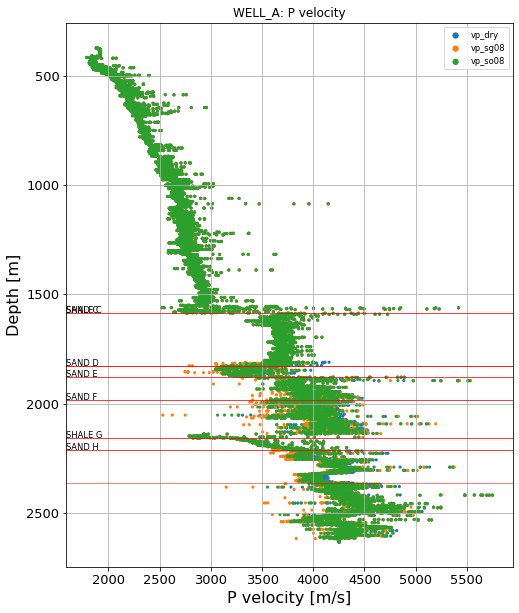

In [18]:
w = wells['WELL_A']
w.depth_plot('P velocity', wis=wis)

## Load the project templates
This action combines the well settings in the *Well settings* sheet (described in the start) with the log templates defined in the *Templates* sheet
<img src="images/LogTemplates.png" />

**Note** that the *unit* is typically taken from the las files themself, and these templates are only occasionally used

In [19]:
templates = uio.project_templates(wp.project_table)

## Load tops or working intervals
Well tops can either be handled by loading a file with well tops. They can be in format exported from Petrel, npd.no, or RokDoc.

Or you can define working intervals in the *Working intervals* sheet of the project table

<img src="images/ProjectTable_working_intervals.png" />

In the above example, the working intervals are defined through
- *Column A*: **Use** 
 - This column in not is use in the current version
- *Column B*: **Given well name**
 - Is the name of wells in the project, as defined in the *Wells table* sheet.  
- *Column C*: **Interval name**
 - name of the working interval
- *Column D & E*: **Top depth** & **Base depth**
 - Depth in meters MD to top and base of the working interval
 
The first five rows of this sheet should not be modified.

Load the working intervals through

In [32]:
wis = uio.project_working_intervals(wp.project_table)

Or load the tops directly from file

In [21]:
tops = uio.read_tops(wp.tops_file, frmt=wp.tops_type)

for well in list(tops.keys()):
    print(' Well: {}'.format(well))

 Well: WELL_C
 Well: WELL_A
 Well: WELL_B
 Well: WELL_F


## Define cutoffs
Cut offs that are used to classify the data (e.g. sands or shales).

The log names (e.g. *vcl*) corresponding to a log type (e.g. *Volume*) must exist in the .las files

In [22]:
cutoffs_sands = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}
cutoffs_shales = {'Volume': ['>', 0.5], 'Porosity': ['<', 0.1]}

## Plotting data
Try plotting some data, for the *Sand E* working interval

Plotting well 6506_9_1


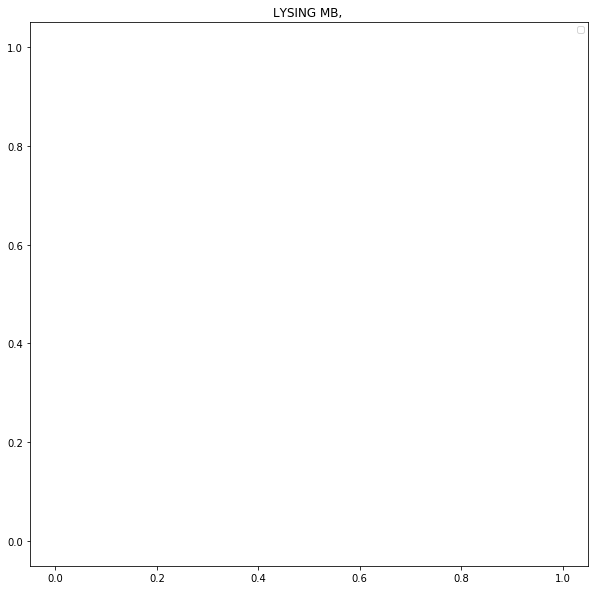

In [34]:
plot_rp.plot_rp(
    wells,
    log_table,
    wis,
    'LYSING MB',
    cutoffs_sands,
    templates,
    plot_type='Phi-Vp',
    show_masked=True,
    edge_color=False
)

Create a depth plot of the P velocity for each well, including the tops

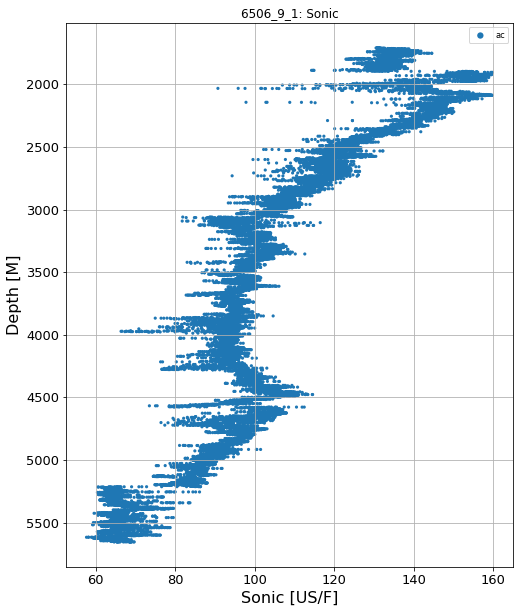

In [33]:
for well in wells.values():
    well.depth_plot(
        log_type='Sonic',
        tops=tops,
        templates=None
    )
